## Deutsch-Jozsa algorithm

In [1]:
# initialization
import numpy as np
# importing Qiskit
from qiskit import IBMQ, Aer, assemble
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile
# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
from enum import Enum
# Define an enumeration for the function types
class FunctionType(Enum):
    CONSTANT = "constant"
    BALANCED = "balanced"

In [3]:
def boolean_function(qc, n, type):    
    for qubit in range(n):
        # 'type' indicates whether the function is 'constant' or 
        # 'balanced'
        if type == FunctionType.CONSTANT.value:
            # Apply the identity operation to the qubit (no change) 
            # for constant functions
            qc.id(qubit)
        elif type == FunctionType.BALANCED.value:
            # Apply a Controlled-NOT (CNOT) gate for balanced 
            # functions
            qc.cx(qubit, n)
        else:
            raise ValueError("Invalid function type. Choose 'CONSTANT' or 'BALANCED'.")
            qc.cx(qubit, n)

    return qc

In [16]:
n = 2
# Or FunctionType.CONSTANT.value
f_x = FunctionType.BALANCED.value

In [17]:
# Create an oracle quantum circuit with n+1 qubits
oracle = QuantumCircuit(n+1)\
# Define the binary string that represents the function values
b_str = "000"
# Place X-gates on qubits corresponding to '1' in b_str
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        # Apply an X gate (bit-flip) to the qubit if the 
        # corresponding bit is '1'
        oracle.x(qubit)
# Use a barrier to visually separate sections of the circuit
oracle.barrier()
# Apply the boolean function f_x to the oracle circuit
oracle = boolean_function(oracle, n, f_x)
# Use another barrier for clarity before the next section
oracle.barrier()
# Place X-gates on qubits corresponding to '1' in b_str after applying 
# the boolean function
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        # Apply an X gate (bit-flip) to the qubit again if the 
        # corresponding bit is '1'
        oracle.x(qubit)

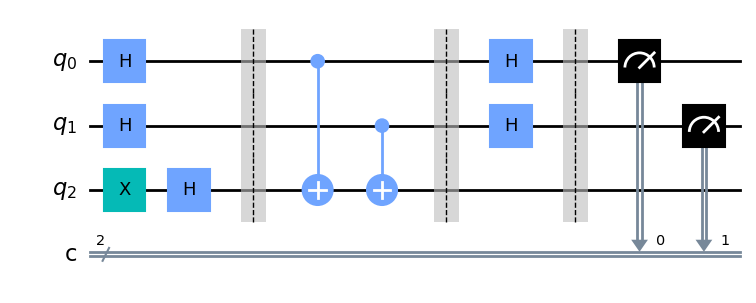

In [18]:
# Create a quantum circuit with n+1 qubits and n classical bits
dj_circuit = QuantumCircuit(n+1, n)
# Apply Hadamard gates to the first n qubits to create superposition
for qubit in range(n):
    dj_circuit.h(qubit)
# Prepare the last qubit in the |-⟩ state
dj_circuit.x(n) # Apply an X gate to flip the state to |1⟩
dj_circuit.h(n) # Apply a Hadamard gate to transform |1⟩ to |-⟩
# Add the oracle to the quantum circuit
dj_circuit = dj_circuit.compose(oracle)
# Repeat Hadamard gates on the first n qubits after the oracle
for qubit in range(n):
    dj_circuit.h(qubit)
# Add a barrier for better visualization of the circuit structure
dj_circuit.barrier()
# Measure the first n qubits and store the results in corresponding 
# classical bits
for i in range(n):
    dj_circuit.measure(i, i)
# Display the quantum circuit
dj_circuit.draw('mpl')

## On Simulator

In [19]:
sim = Aer.get_backend('aer_simulator')
# we need to mMake a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
dj_circuit_sim = dj_circuit.copy()
dj_circuit_sim.save_statevector()
qobj = assemble(dj_circuit_sim)

In [20]:
result = sim.run(qobj).result()

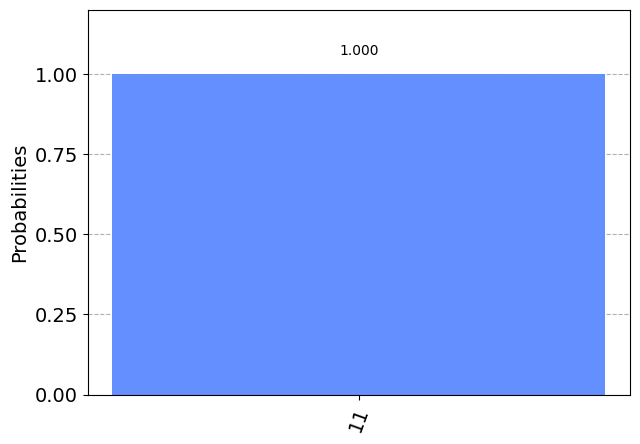

In [21]:
counts = result.get_counts()
plot_histogram(counts)

## On Real IBM quantum device

In [ ]:
# Load the IBM Quantum account for access to the available resources
IBMQ.load_account()
# Retrieve the IBM Quantum provider for the specified hub
provider = IBMQ.get_provider(hub='ibm-q')
# Find the least busy backend that can accommodate the required 
# number of qubits (n+1)
backend = least_busy(provider.backends(filters=lambda x:   
  x.configuration().n_qubits >= (n+1) and
  not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
# Transpile the circuit for the specified backend with the highest 
# optimization level
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
# Execute the transpiled circuit on the backend
job = backend.run(transpiled_dj_circuit)
# Monitor the job status at 2-second intervals
job_monitor(job, interval=2)

In [ ]:
# Get the results of the computation
results = job.result()
# Retrieve the counts of measurement outcomes
answer = results.get_counts()
# Plot a histogram of the measurement results
plot_histogram(answer)